# Análises Macroeconômicas #

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt

In [5]:
dataInicial = "01/01/2000"
dataFinal = "01/01/2010"

## Consultas às APIS do BACEN ##

### Histórico do PTAX Dólar/Real ###

In [6]:
def consulta_bc(dataInicial, dataFinal):
    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.10813/dados?formato=json&dataInicial={dataInicial}&dataFinal={dataFinal}"
    print(f"Buscando: {dataInicial} até {dataFinal}")
    
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

# Lista para armazenar os DataFrames de cada década
frames = []

for i in range(2000, 2026, 10):
    # Define o fim do intervalo: ou i+10 ou o limite 2025
    f = i + 10 if (i + 10) <= 2026 else 2026
    
    data_ini = f"01/01/{i}"
    data_fim = f"01/01/{f}" # Ajustado para 31/12 para pegar o ano cheio
    
    # Chama a função e guarda o resultado na lista
    df_intervalo = consulta_bc(data_ini, data_fim)
    frames.append(df_intervalo)

# Concatena todos os intervalos em um único DataFrame final
historico_dolar = pd.concat(frames)
historico_dolar.columns = ['dolar_ptax']

print("\nResultados finais (últimas linhas):")
historico_dolar.head(5)

Buscando: 01/01/2000 até 01/01/2010
Buscando: 01/01/2010 até 01/01/2020
Buscando: 01/01/2020 até 01/01/2026

Resultados finais (últimas linhas):


,dolar_ptax
data,
2000-01-03,1.8003
2000-01-04,1.8329
2000-01-05,1.8536
2000-01-06,1.8453
2000-01-07,1.8273


### Histórico da taxa básica de juros (SELIC) ###

In [7]:
def consulta_selic(dataInicial, dataFinal):
    # Código 11 é a Selic acumulada no mês / Código 432 é a Selic Meta (anualizada)
    # Usaremos o 11 para seguir o padrão de série histórica
    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial={dataInicial}&dataFinal={dataFinal}"
    print(f"Buscando Selic: {dataInicial} até {dataFinal}")
    
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

frames_selic = []

for i in range(2000, 2026, 10):
    f = i + 10 if (i + 10) <= 2026 else 2026
    
    # Definindo os períodos de análise
    inicio = f"01/01/{i}"
    fim = f"01/01/{f}"
    
    df_intervalo = consulta_selic(inicio, fim)
    frames_selic.append(df_intervalo)

# Consolida os dados
historico_selic = pd.concat(frames_selic)
historico_selic.columns = ['Selic_Diaria']

print("\nÚltimos registros da Selic:")
historico_selic.head(5)

Buscando Selic: 01/01/2000 até 01/01/2010
Buscando Selic: 01/01/2010 até 01/01/2020
Buscando Selic: 01/01/2020 até 01/01/2026

Últimos registros da Selic:


,Selic_Diaria
data,
2000-01-03,0.069186
2000-01-04,0.069186
2000-01-05,0.069220
2000-01-06,0.069286
2000-01-07,0.069286


In [8]:
# Convertendo SELIC diária para anual
historico_selic['Selic_Anual'] = (1 + historico_selic['Selic_Diaria']/100) ** 252 - 1

historico_selic.head(3)

,Selic_Diaria,Selic_Anual
data,,
2000-01-03,0.069186,0.190399
2000-01-04,0.069186,0.190399
2000-01-05,0.069220,0.190501


### Histórico da taxa básica de juros (SELIC) ###

In [9]:
def consulta_inflacao(dataInicial, dataFinal):
    # Série 433: IPCA - Variação mensal (%)
    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.13522/dados?formato=json&dataInicial={dataInicial}&dataFinal={dataFinal}"
    print(f"Buscando IPCA: {dataInicial} até {dataFinal}")
    
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

frames_ipca = []

for i in range(2000, 2026, 10):
    f = i + 10 if (i + 10) <= 2026 else 2026
    inicio = f"01/01/{i}"
    fim = f"01/01/{f}"
    
    df_intervalo = consulta_inflacao(inicio, fim)
    frames_ipca.append(df_intervalo)

historico_ipca = pd.concat(frames_ipca)
historico_ipca.columns = ['ipca_anual']

print("\nÚltimos registros do IPCA:")
print(historico_ipca.tail())

Buscando IPCA: 01/01/2000 até 01/01/2010
Buscando IPCA: 01/01/2010 até 01/01/2020
Buscando IPCA: 01/01/2020 até 01/01/2026

Últimos registros do IPCA:
            ipca_anual
data                  
2025-09-01        5.17
2025-10-01        4.68
2025-11-01        4.46
2025-12-01        4.26
2026-01-01        4.44


### Mesclando os dados históricos do preço do dólar e da taxa SELIC ###

In [10]:
df = pd.merge(historico_dolar, historico_selic, how='left', left_index=True, right_index=True)
df.columns = ['Dolar', 'Selic_Diaria', 'Selic_Anual']

In [11]:
df = pd.merge(df, historico_ipca, how='outer', left_index=True, right_index=True)

In [12]:
df.rename(columns={'Dolar': 'Dólar (PTAX)', 'Selic_Diaria': 'Selic Diária (%)', 'Selic_Anual': 'Selic Anual (%)', 'ipca_anual': 'IPCA Anual (%)'}, inplace=True)

In [13]:
df.head(45)

,Dólar (PTAX),Selic Diária (%),Selic Anual (%),IPCA Anual (%)
data,,,,
2000-01-01,NaN,NaN,NaN,8.85
2000-01-03,1.8003,0.069186,0.190399,NaN
2000-01-04,1.8329,0.069186,0.190399,NaN
2000-01-05,1.8536,0.069220,0.190501,NaN
2000-01-06,1.8453,0.069286,0.190699,NaN
2000-01-07,1.8273,0.069286,0.190699,NaN
2000-01-10,1.8153,0.069120,0.190201,NaN
2000-01-11,1.8211,0.068986,0.189799,NaN
2000-01-12,1.8306,0.068819,0.189299,NaN


In [14]:
df['IPCA Anual (%)'] = (df['IPCA Anual (%)'] / 100)

In [15]:
# 1. Remover duplicatas de índice (causadas pela sobreposição do loop)
# Isso remove as datas repetidas mantendo a primeira entrada
df = df[~df.index.duplicated(keep='first')]

# 2. Garantir que o índice esteja em ordem cronológica
df = df.sort_index()

# 3. Criar o novo intervalo diário
idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# 4. Reindexar e preencher os buracos (ffill)
# Agora o erro de 'duplicate labels' não acontecerá mais
df = df.reindex(idx).ffill()

# 5. (Opcional) bfill para garantir que o início da tabela não tenha NaNs
df = df.bfill()

print("Duplicatas removidas e dados preenchidos com sucesso!")
print(df.head(10))

Duplicatas removidas e dados preenchidos com sucesso!
            Dólar (PTAX)  Selic Diária (%)  Selic Anual (%)  IPCA Anual (%)
2000-01-01        1.8003          0.069186         0.190399          0.0885
2000-01-02        1.8003          0.069186         0.190399          0.0885
2000-01-03        1.8003          0.069186         0.190399          0.0885
2000-01-04        1.8329          0.069186         0.190399          0.0885
2000-01-05        1.8536          0.069220         0.190501          0.0885
2000-01-06        1.8453          0.069286         0.190699          0.0885
2000-01-07        1.8273          0.069286         0.190699          0.0885
2000-01-08        1.8273          0.069286         0.190699          0.0885
2000-01-09        1.8273          0.069286         0.190699          0.0885
2000-01-10        1.8153          0.069120         0.190201          0.0885


Plotar os dados de câmbio e SELIC em um gráfico

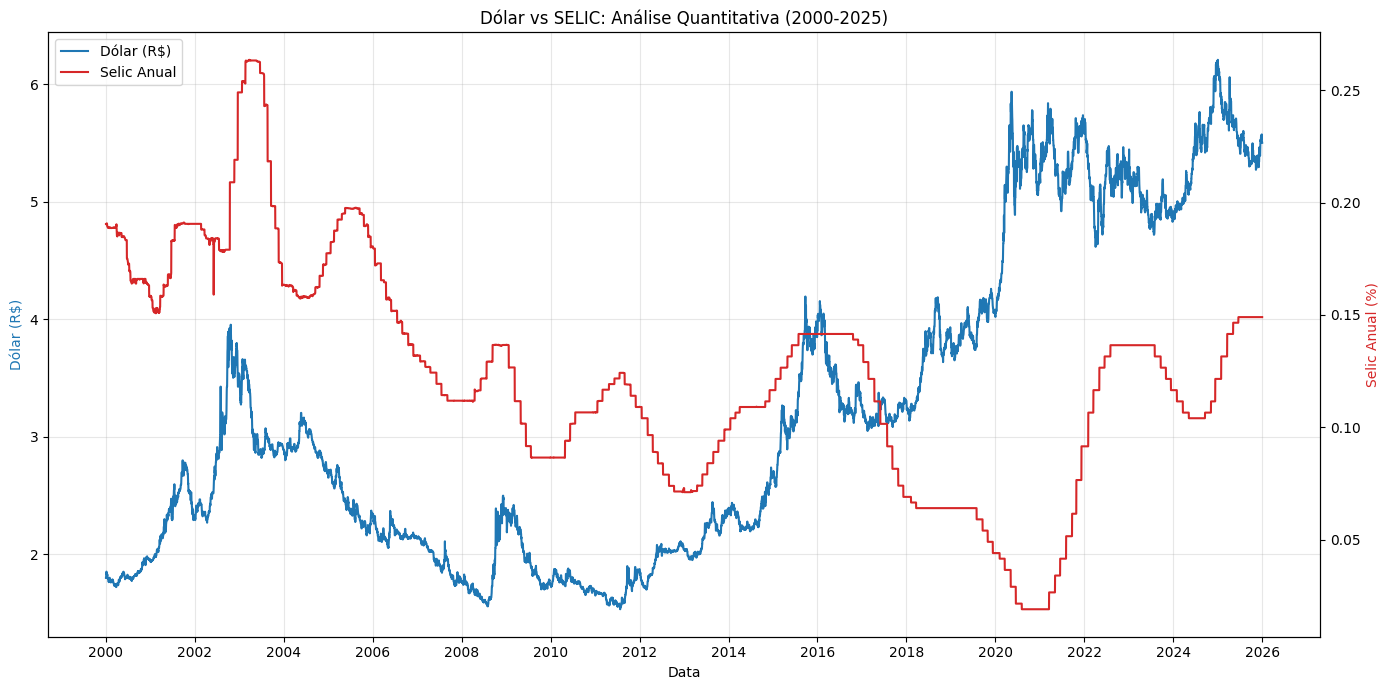

Correlação calculada: -0.2681


In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 4. Visualização
fig, ax1 = plt.subplots(figsize=(14, 7)) # Aumentei um pouco a largura para caber os rótulos

ax1.set_xlabel('Data')
ax1.set_ylabel('Dólar (R$)', color='tab:blue')
lns1 = ax1.plot(df.index, df['Dólar (PTAX)'], color='tab:blue', lw=1.5, label='Dólar (R$)')

# Criando o segundo eixo
ax2 = ax1.twinx()
ax2.set_ylabel('Selic Anual (%)', color='tab:red')
lns2 = ax2.plot(df.index, df['Selic Anual (%)'], color='tab:red', lw=1.5, label='Selic Anual')

# --- CONFIGURAÇÃO DO EIXO X (2 EM 2 ANOS) ---
ax1.xaxis.set_major_locator(mdates.YearLocator(2)) # Define o intervalo de 2 anos
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Formata para mostrar apenas o ano
plt.xticks(rotation=45) # Rotaciona para evitar sobreposição

# --- LEGENDA UNIFICADA ---
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

plt.title('Dólar vs SELIC: Análise Quantitativa (2000-2025)')
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Correlação calculada: {df.corr().iloc[0,1]:.4f}")

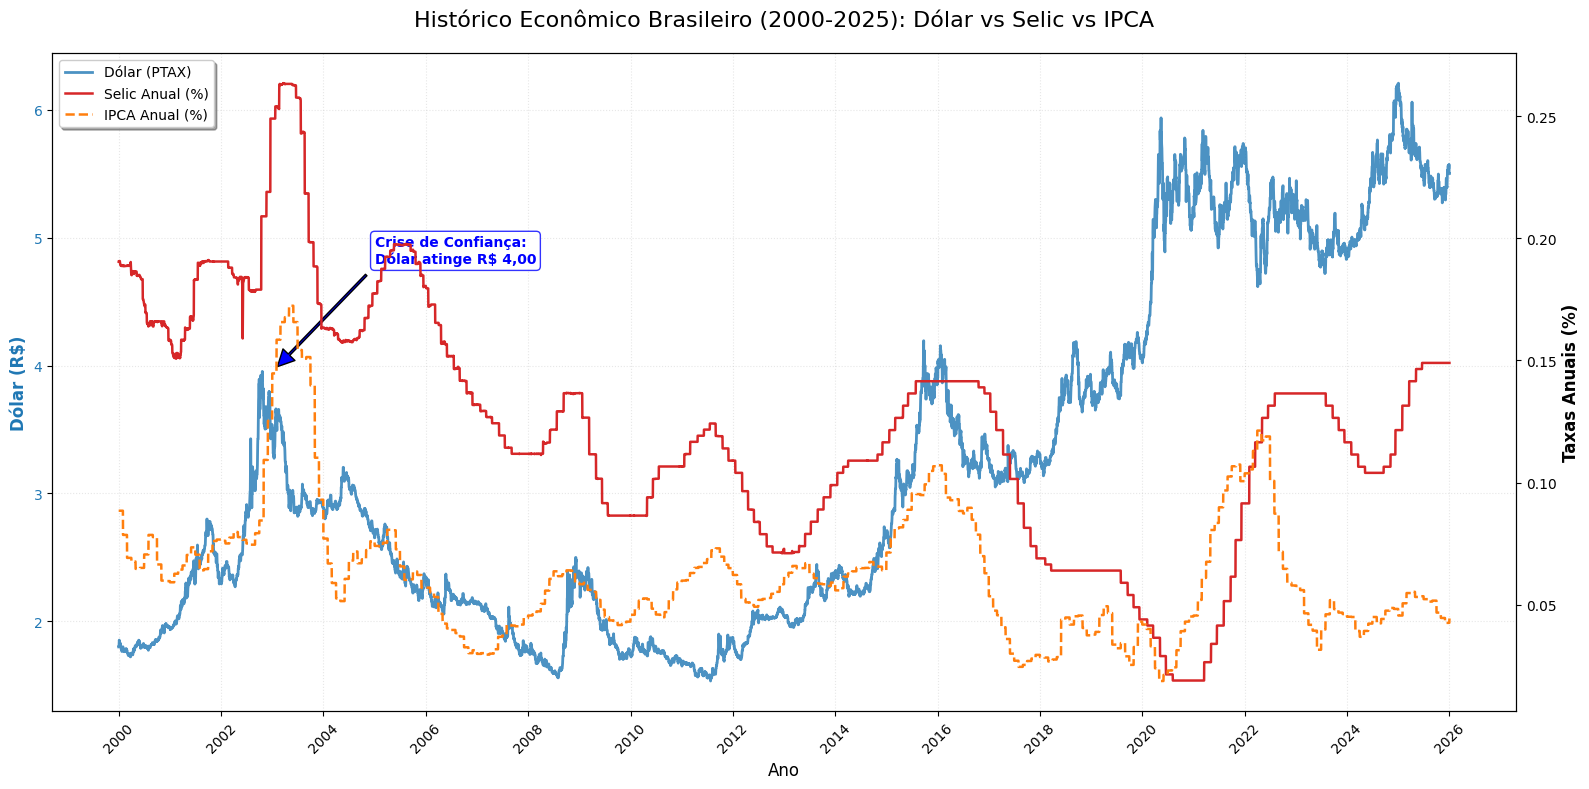


--- MATRIZ DE CORRELAÇÃO ---
                  Dólar (PTAX)  Selic Diária (%)  Selic Anual (%)  \
Dólar (PTAX)          1.000000         -0.268063        -0.260974   
Selic Diária (%)     -0.268063          1.000000         0.999502   
Selic Anual (%)      -0.260974          0.999502         1.000000   
IPCA Anual (%)        0.001190          0.572239         0.582703   

                  IPCA Anual (%)  
Dólar (PTAX)            0.001190  
Selic Diária (%)        0.572239  
Selic Anual (%)         0.582703  
IPCA Anual (%)          1.000000  


In [17]:
fig, ax1 = plt.subplots(figsize=(16, 8))

# Eixo Esquerdo: Dólar
ax1.set_xlabel('Ano', fontsize=12)
ax1.set_ylabel('Dólar (R$)', color='tab:blue', fontsize=12, fontweight='bold')
lns1 = ax1.plot(df.index, df['Dólar (PTAX)'], color='tab:blue', lw=2, label='Dólar (PTAX)', alpha=0.8)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Eixo Direito: Taxas Anuais (%)
ax2 = ax1.twinx()
ax2.set_ylabel('Taxas Anuais (%)', color='black', fontsize=12, fontweight='bold')
lns2 = ax2.plot(df.index, df['Selic Anual (%)'], color='tab:red', lw=1.8, label='Selic Anual (%)')
lns3 = ax2.plot(df.index, df['IPCA Anual (%)'], color='tab:orange', lw=1.8, ls='--', label='IPCA Anual (%)')
ax2.tick_params(axis='y')

# Formatação do Eixo X
ax1.xaxis.set_major_locator(mdates.YearLocator(2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45)

# Legenda Unificada
lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left', frameon=True, shadow=True)

# 5. Anotações Históricas (Crise de 2003)
# Seta do Dólar
ax1.annotate('Crise de Confiança:\nDólar atinge R$ 4,00', 
             xy=(pd.Timestamp('2003-01-01'), 3.95), 
             xytext=(pd.Timestamp('2005-01-01'), 4.8),
             arrowprops=dict(facecolor='blue', shrink=0.05, width=1.5),
             fontsize=10, color='blue', fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue", alpha=0.8))

# Seta do IPCA
ax2.annotate('Pico da Inflação (IPCA)', 
             xy=(pd.Timestamp('2003-05-01'), 17.2), 
             xytext=(pd.Timestamp('2007-01-01'), 20),
             arrowprops=dict(facecolor='orange', shrink=0.05, width=1.5),
             fontsize=10, color='darkorange', fontweight='bold')

# Seta da Selic
ax2.annotate('Resposta do BC:\nSelic a 26,5%', 
             xy=(pd.Timestamp('2003-02-01'), 26.5), 
             xytext=(pd.Timestamp('1997-01-01'), 28),
             arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
             fontsize=10, color='red', fontweight='bold')

plt.title('Histórico Econômico Brasileiro (2000-2025): Dólar vs Selic vs IPCA', fontsize=16, pad=20)
ax1.grid(alpha=0.3, linestyle=':')

# Ajuste final e exibição
plt.tight_layout()
plt.show()

# 6. Análise de Correlação
print("\n--- MATRIZ DE CORRELAÇÃO ---")
print(df.corr())

No gráfico acima, é possível observar que, em 2022, o aumento na taxa básica de juros provocou uma queda imediata no preço do dólar

Importando a taxa básica de juros americana (FED RATE)

In [18]:
from fredapi import Fred
import pandas as pd

# Substitua pela sua chave real
fred = Fred(api_key='740ee3f0157b9dbd3fe23ce1c4927102')

# FEDFUNDS é a taxa mensal; para a diária use 'DFF'
fed_rate = fred.get_series('FEDFUNDS', observation_start='2000-01-01')

# Transformando em DataFrame para analisar com ML
df_fed = pd.DataFrame(fed_rate, columns=['Fed_Rate'])

In [19]:
df_fed

,Fed_Rate
2000-01-01,5.45
2000-02-01,5.73
2000-03-01,5.85
2000-04-01,6.02
2000-05-01,6.27
...,...
2025-09-01,4.22
2025-10-01,4.09
2025-11-01,3.88
2025-12-01,3.72


In [20]:
df_juros = pd.merge(df, df_fed, how='left', left_index=True, right_index=True)

In [21]:
df_juros.rename(columns={'Fed_Rate': 'Fed Rate (%)'}, inplace=True)

In [22]:
idx = pd.date_range(start=df_juros.index.min(), end=df_juros.index.max(), freq='D')
df_juros = df_juros.reindex(idx)

# 2. A Mágica: Preencher os dados em branco com o último valor disponível
df_juros = df_juros.ffill()

# Se você quiser preencher apenas colunas específicas:
# df[['Dolar', 'Selic']] = df[['Dolar', 'Selic']].ffill()

print(df_juros.head(10))

            Dólar (PTAX)  Selic Diária (%)  Selic Anual (%)  IPCA Anual (%)  \
2000-01-01        1.8003          0.069186         0.190399          0.0885   
2000-01-02        1.8003          0.069186         0.190399          0.0885   
2000-01-03        1.8003          0.069186         0.190399          0.0885   
2000-01-04        1.8329          0.069186         0.190399          0.0885   
2000-01-05        1.8536          0.069220         0.190501          0.0885   
2000-01-06        1.8453          0.069286         0.190699          0.0885   
2000-01-07        1.8273          0.069286         0.190699          0.0885   
2000-01-08        1.8273          0.069286         0.190699          0.0885   
2000-01-09        1.8273          0.069286         0.190699          0.0885   
2000-01-10        1.8153          0.069120         0.190201          0.0885   

            Fed Rate (%)  
2000-01-01          5.45  
2000-01-02          5.45  
2000-01-03          5.45  
2000-01-04          5.

In [23]:
df_juros['Fed Rate (%)'] = (df_juros['Fed Rate (%)']/100)

In [24]:
df_juros.head(5)

,Dólar (PTAX),Selic Diária (%),Selic Anual (%),IPCA Anual (%),Fed Rate (%)
2000-01-01,1.8003,0.069186,0.190399,0.0885,0.0545
2000-01-02,1.8003,0.069186,0.190399,0.0885,0.0545
2000-01-03,1.8003,0.069186,0.190399,0.0885,0.0545
2000-01-04,1.8329,0.069186,0.190399,0.0885,0.0545
2000-01-05,1.8536,0.069220,0.190501,0.0885,0.0545


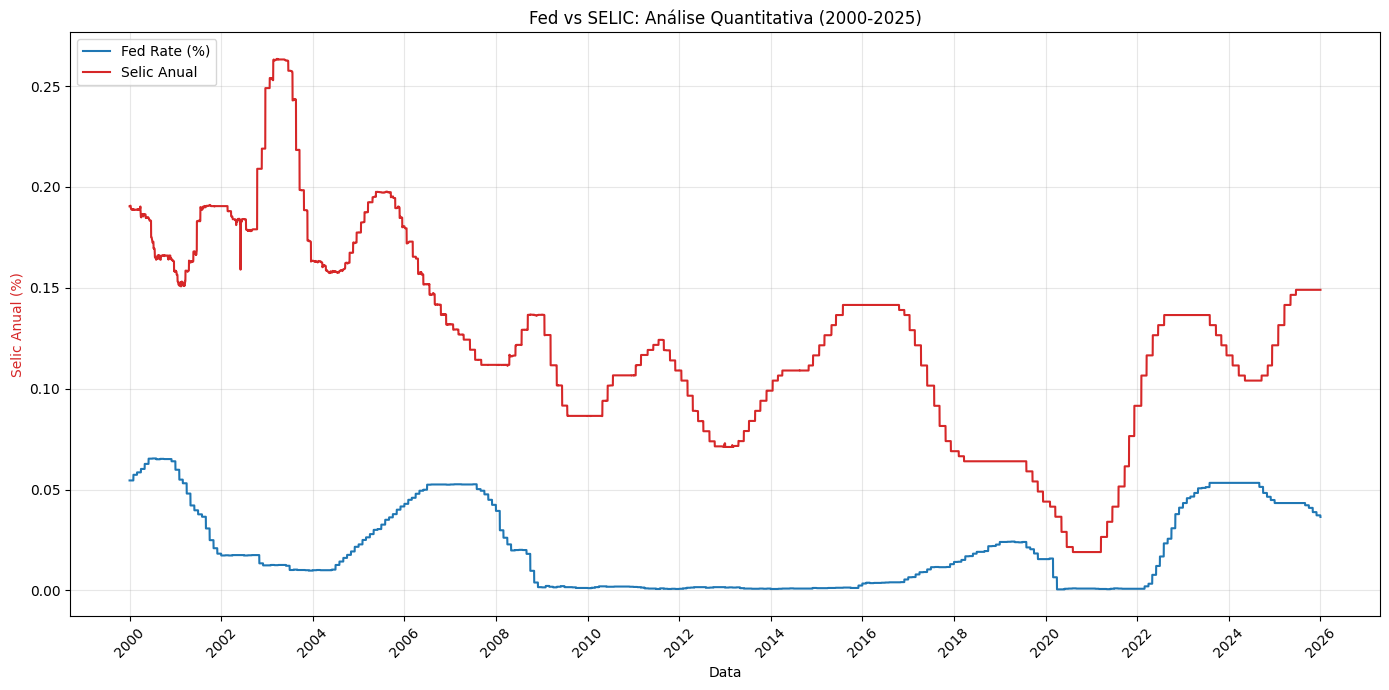

Correlação calculada: -0.2681


In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 4. Visualização
fig, ax1 = plt.subplots(figsize=(14, 7)) # Aumentei um pouco a largura para caber os rótulos

ax1.set_xlabel('Data')
ax1.set_ylabel('Fed Rate (%)', color='tab:blue')
lns1 = ax1.plot(df_juros.index, df_juros['Fed Rate (%)'], color='tab:blue', lw=1.5, label='Fed Rate (%)')

# Criando o segundo eixo

ax1.set_ylabel('Selic Anual (%)', color='tab:red')
lns2 = ax1.plot(df_juros.index, df_juros['Selic Anual (%)'], color='tab:red', lw=1.5, label='Selic Anual')

# --- CONFIGURAÇÃO DO EIXO X (2 EM 2 ANOS) ---
ax1.xaxis.set_major_locator(mdates.YearLocator(2)) # Define o intervalo de 2 anos
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Formata para mostrar apenas o ano
plt.xticks(rotation=45) # Rotaciona para evitar sobreposição

# --- LEGENDA UNIFICADA ---
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

plt.title('Fed vs SELIC: Análise Quantitativa (2000-2025)')
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Correlação calculada: {df.corr().iloc[0,1]:.4f}")

In [26]:
df_juros.to_csv('archives/dados_bacen.csv')